In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# 数据预处理

In [42]:
df = pd.read_csv("learndata/pollution.csv")
df.drop(columns=['No'], inplace=True)

pd.to_datetime(df[['year', 'month','day', 'hour']])

df['datetime'] = df.apply(lambda x: pd.to_datetime(f"{x['year']}-{x['month']}-{x['day']} {x['hour']}:00:00"), axis=1)

df.drop(columns=['year', 'month','day', 'hour'], axis=1, inplace=True)

# df.insert(0, 'datetime', df.pop('datetime'))
# df.set_index('datetime', inplace=True)
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
df.dropna(inplace=True)

df.to_csv("learndata/pollution_improve.csv", index=False)

   pm2.5  DEWP  TEMP    PRES cbwd   Iws  Is  Ir            datetime
1    NaN   -21 -12.0  1020.0   NW  4.92   0   0 2010-01-01 01:00:00
2    NaN   -21 -11.0  1019.0   NW  6.71   0   0 2010-01-01 02:00:00
3    NaN   -21 -14.0  1019.0   NW  9.84   0   0 2010-01-01 03:00:00


# 模型搭建

In [81]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# 输入序列(t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# 预测序列(t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# 把所有放在一起
	agg = concat(cols, axis=1)
	agg.columns = names
	# 删除空值行
	if dropnan:
		agg.dropna(inplace=True)
	return agg

dataset = pd.read_csv('learndata/pollution_improve.csv', header=0, index_col=0)
print(dataset.head(3))
values = dataset.values
encoder = LabelEncoder()
values[:,3] = encoder.fit_transform(values[:,3])
values = values.astype('float32')
print(values[1])
sclaer = MinMaxScaler(feature_range=(0,1))
scaled = sclaer.fit_transform(values)
reframed = series_to_supervised(scaled,1,1)
# 删除我们不想预测的天气数据列，只留下pollution列
reframed.drop(reframed.columns[[8, 9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

           dew  temp   press wnd_dir  wnd_spd  snow  rain
pollution                                                
129.0      -16  -4.0  1020.0      SE     1.79     0     0
148.0      -15  -4.0  1020.0      SE     2.68     0     0
159.0      -11  -5.0  1021.0      SE     3.57     0     0
[ -15.     -4.   1020.      2.      2.68    0.      0.  ]
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.352941   0.245902   0.527273   0.666667   0.002372   0.000000   
2   0.367647   0.245902   0.527273   0.666667   0.003947   0.000000   
3   0.426471   0.229508   0.545454   0.666667   0.005522   0.000000   
4   0.485294   0.229508   0.563637   0.666667   0.008690   0.037037   
5   0.485294   0.229508   0.563637   0.666667   0.010265   0.074074   

   var7(t-1)   var1(t)  
1        0.0  0.367647  
2        0.0  0.426471  
3        0.0  0.485294  
4        0.0  0.485294  
5        0.0  0.485294  


In [86]:
values = reframed.values
n_train_hours = 365*24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]

train_x = train_x.reshape(train_x.shape[0], 1 , train_x.shape[1])
test_x = test_x.reshape(test_x.shape[0], 1, test_x.shape[1])

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(8760, 1, 7) (8760,) (32996, 1, 7) (32996,)


In [102]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
class LSTMmodel:
    def __init__(self, input_shape, units=100):
        self.input_shape = input_shape
        self.units = units
        self.model = self.build_model(input_shape)
    
    def build_model(self, input_shape):
        model = Sequential()
        model.add(LSTM(self.units, input_shape=input_shape))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        return model
        
    def train(self, train_x, train_y, epochs=50, batch_size=32):
        self.model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size)
        
    def predict(self, X):
        return self.model.predict(X)
	


LSTM_model = LSTMmodel(input_shape=train_x.shape[1:], units=100) 
LSTM_model.train(train_x, train_y, epochs=100, batch_size=72)


Epoch 1/100
122/122 [==============================] - 2s 3ms/step - loss: 0.1806
Epoch 2/100
122/122 [==============================] - 0s 3ms/step - loss: 0.0383
Epoch 3/100
122/122 [==============================] - 0s 3ms/step - loss: 0.0215
Epoch 4/100
122/122 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 5/100
122/122 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 6/100
122/122 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 7/100
122/122 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 8/100
122/122 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 9/100
122/122 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 10/100
122/122 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 11/100
122/122 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 12/100
122/122 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 13/100


1032/1032 [==============================] - 1s 1ms/step
[[0.2906839 ]
 [0.3051163 ]
 [0.31942117]
 ...
 [0.2616417 ]
 [0.26169014]
 [0.2616932 ]]


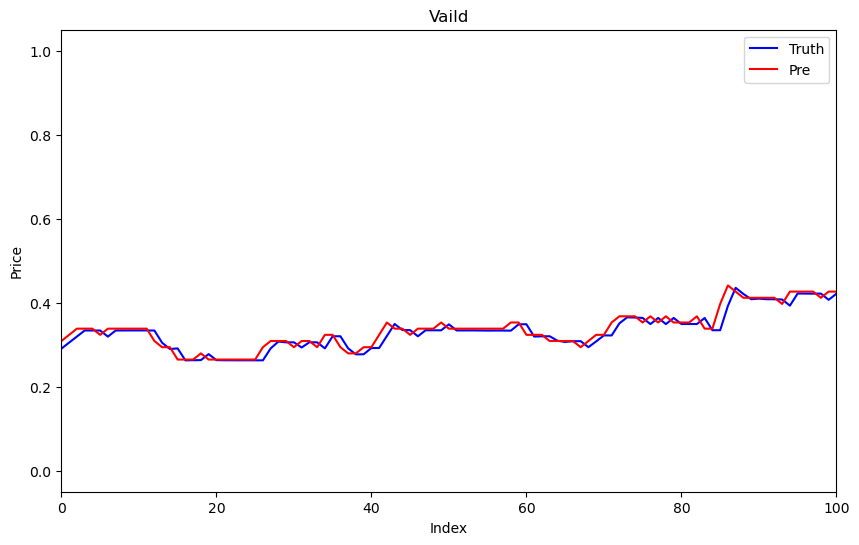

In [105]:
pred_x = LSTM_model.predict(test_x)
print(pred_x)

plt.figure(figsize=(10, 6))

# 绘制真实值的折线图
plt.plot(pred_x, label='pred', color='blue')

# 绘制预测值的折线图
plt.plot(test_y, label='Truth', color='red')

# 添加图例
plt.legend()

# 添加标题和轴标签
plt.title('Vaild')
plt.xlabel('Index')
plt.ylabel('Price')
plt.xlim(0, 100)
# 显示图形
plt.show()